# Import Library

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.utils import shuffle
import random
from tqdm import tqdm
from PIL import Image, ImageEnhance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Preparation

In [ ]:
# Accessing all folder names to get list of labels.

image_path = '/content/drive/MyDrive/face_age_images/'
image_names = os.listdir(image_path)

In [ ]:
len(image_names)

9825

In [ ]:
# Path Haar Cascade
haar_cascade_path = "/content/drive/MyDrive/PCVK_2024/Images/haarcascades/haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar_cascade_path)

# Path dataset
dataset_path = '/content/drive/MyDrive/face_age_images/'
cleaned_dataset_path = "/content/drive/MyDrive/PBL/dataset/cleaned_dataset"
os.makedirs(cleaned_dataset_path, exist_ok=True)

# # Face Detection
# def has_face(image_path):
#     img = cv2.imread(image_path)
#     if img is None:
#         return False

#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
#     return len(faces) == 0

# # Iteration
# for image_name in tqdm(os.listdir(dataset_path)):
#     image_path = os.path.join(dataset_path, image_name)

#     if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
#         continue

#     if has_face(image_path):
#         cleaned_image_path = os.path.join(cleaned_dataset_path, image_name)
#         cv2.imwrite(cleaned_image_path, cv2.imread(image_path))

In [ ]:
# Accessing all folder names to get list of labels.

cleaned_dataset_path = '/content/drive/MyDrive/PBL/dataset/cleaned_dataset'
cleaned_names = os.listdir(cleaned_dataset_path)

In [ ]:
len(cleaned_names)

4633

# Create Dataframe

In [ ]:
# Creating a new dataframe to hold all filenames, corresponding ages and class labels.

images_df = pd.DataFrame()
images_df['filename'] = os.listdir(cleaned_dataset_path)
images_df['age'] = images_df['filename'].map(lambda img_name : np.uint8(img_name.split("_")[0]))

images_df.head()

,filename,age
0,021_3095.png,21
1,021_2919.png,21
2,021_2675.png,21
3,021_2172.png,21
4,021_2211.png,21


In [ ]:
csv_path = '/content/drive/MyDrive/PBL/input_output'

if not os.path.exists(csv_path):
    os.makedirs(csv_path)

In [ ]:
# Exporting above created dataframe as a CSV file.
images_df.to_csv(os.path.join(csv_path, 'images_summary.csv'), index=True, index_label='age')

# Barplot

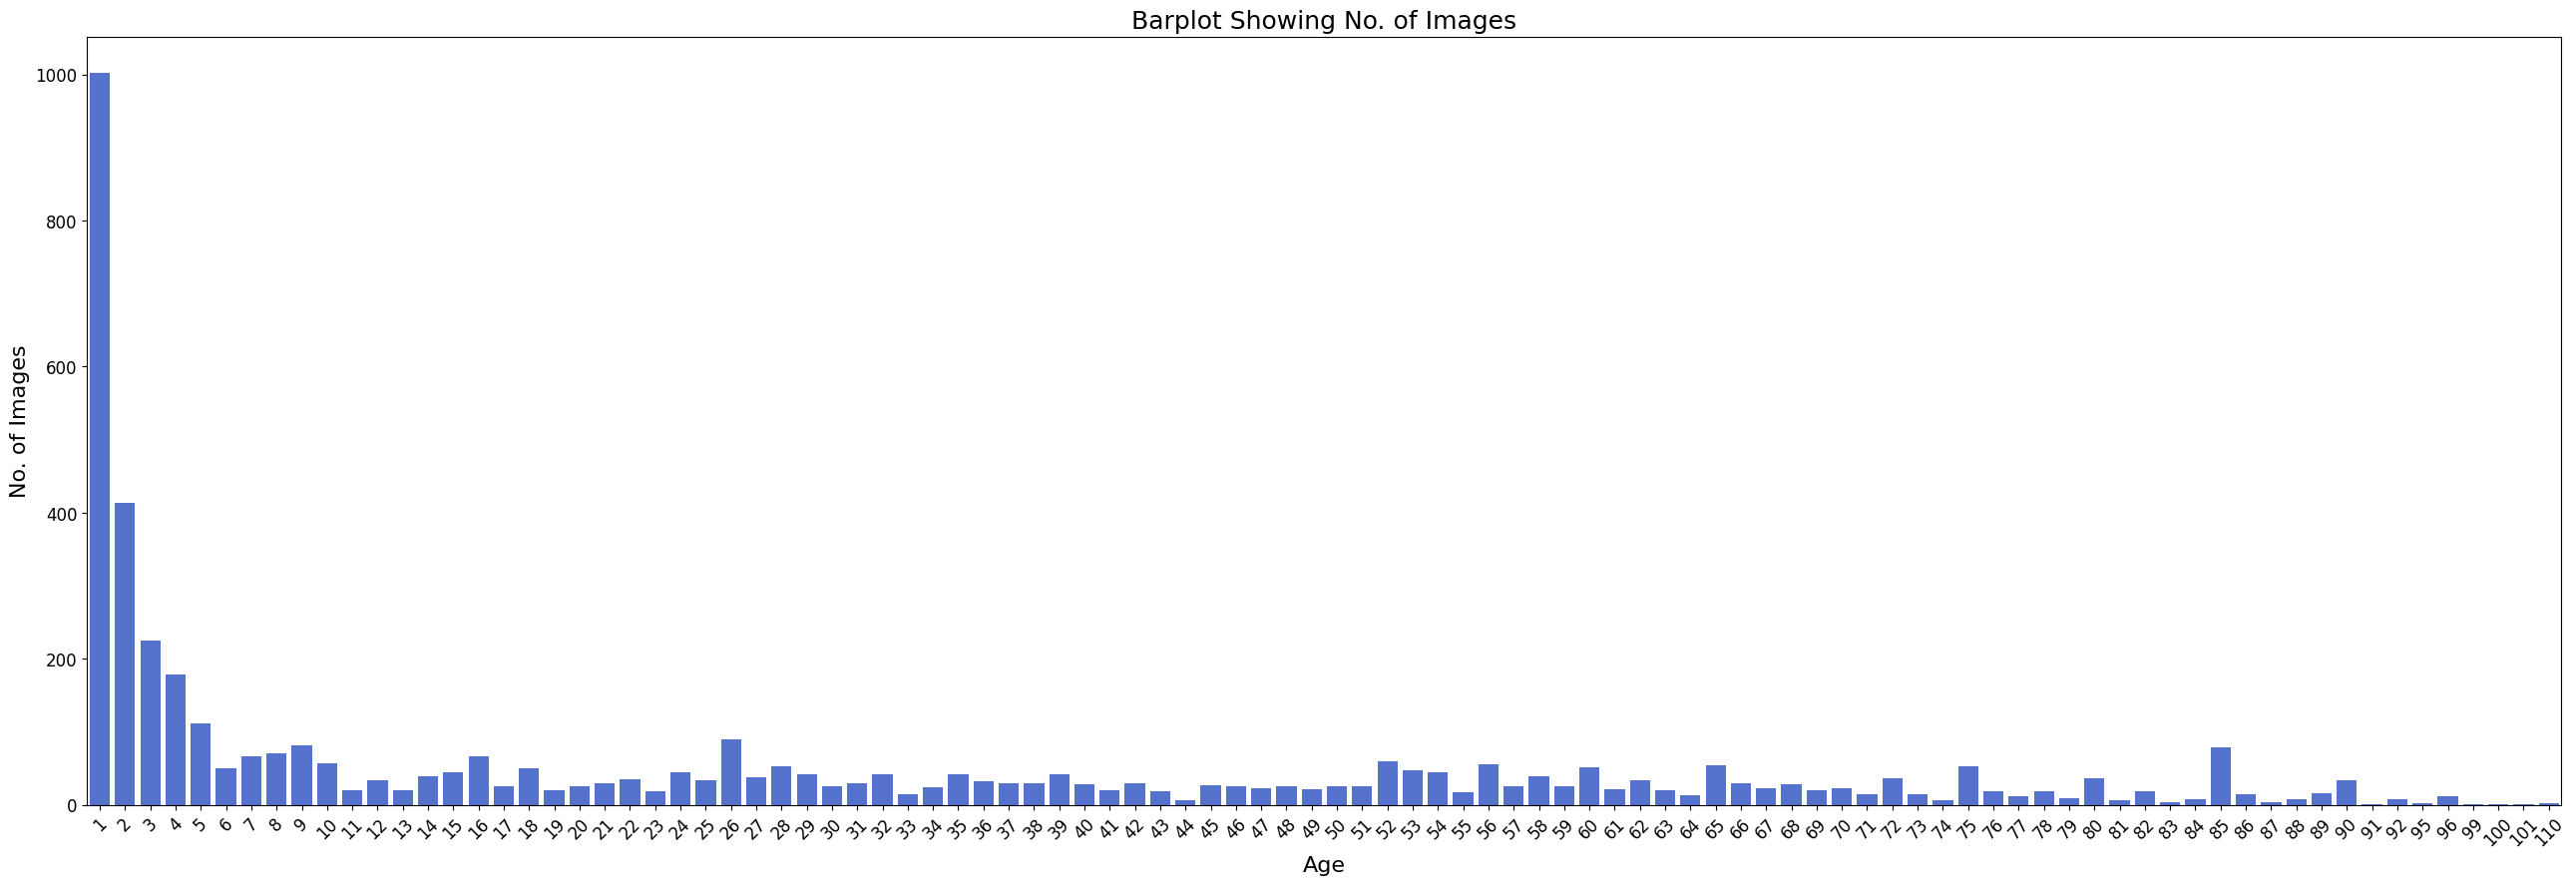

In [ ]:
age_counts = images_df['age'].value_counts().sort_index()

# Creating barplot
plt.figure(figsize=(32, 10))
ax = sns.barplot(x=age_counts.index, y=age_counts.values, color='royalblue')

ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelrotation=45)

plt.xlabel("Age", fontsize=16)
plt.ylabel("No. of Images", fontsize=16)
plt.title("Barplot Showing No. of Images", fontsize=18)

plt.show()

In [ ]:
# Defining a function to return the class labels corresponding to the age-ranges shown above.
def class_labels(age):
    if 0 <= age <= 5:
        return 0
    elif 6 <= age <= 10:
        return 1
    elif 11 <= age <= 15:
        return 2
    elif 16 <= age <= 20:
        return 3
    elif 21 <= age <= 30:
        return 4
    elif 31 <= age <= 40:
        return 5
    elif 41 <= age <= 50:
        return 6
    elif 51 <= age <= 60:
        return 7
    elif 61 <= age <= 70:
        return 8
    elif 71 <= age <= 80:
        return 9
    elif 81 <= age <= 110:
        return 10
    else:
        return 10

In [ ]:
# Creating a new dataframe to hold all filenames, corresponding ages and class labels.

plot_df = pd.DataFrame()
plot_df['filename'] = cleaned_names
plot_df['age'] = plot_df['filename'].map(lambda img_name : np.uint8(img_name.split("_")[0]))
plot_df['target'] = plot_df['age'].map(class_labels)

plot_df.head(5000)

,filename,age,target
0,021_3095.png,21,4
1,021_2919.png,21,4
2,021_2675.png,21,4
3,021_2172.png,21,4
4,021_2211.png,21,4
...,...,...,...
4628,060_8983.png,60,7
4629,060_8326.png,60,7
4630,060_9401.png,60,7
4631,060_9639.png,60,7


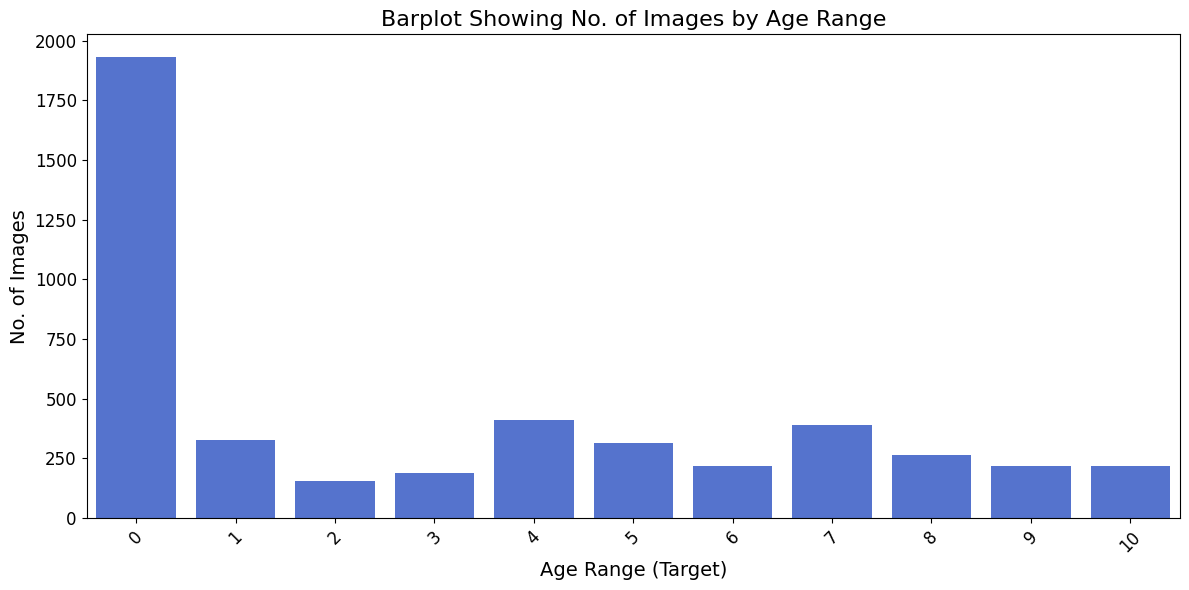

In [ ]:
target_counts = plot_df['target'].value_counts().sort_index()

# Creating barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=target_counts.index, y=target_counts.values, color='royalblue')

ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelrotation=45)

plt.xlabel("Age Range (Target)", fontsize=14)
plt.ylabel("No. of Images", fontsize=14)
plt.title("Barplot Showing No. of Images by Age Range", fontsize=16)

plt.tight_layout()
plt.show()

# Augmentation



In [ ]:
def augment_images_limited_by_target(
    df,  # DataFrame dengan kolom filename, age, dan target
    max_per_target=500,  # Batas maksimum gambar per target
    max_augmentations_per_image=3
):
    import os
    import random
    from PIL import Image, ImageEnhance
    import pandas as pd

    save_augmented_path = "/content/drive/MyDrive/PBL/dataset/augmented_dataset/"
    image_column = "filename"
    age_column = "age"
    target_column = "target"

    os.makedirs(save_augmented_path, exist_ok=True)
    augmented_data = []
    current_count_per_target = {target: 0 for target in df[target_column].unique()}

    for index, row in df.iterrows():
        target = row[target_column]
        age = row[age_column]

        # Jika target sudah mencapai batas maksimum, lewati
        if current_count_per_target[target] >= max_per_target:
            continue

        # Path ke gambar asli
        image_path = os.path.join(cleaned_dataset_path, row[image_column])

        # Cek apakah file ada
        if not os.path.exists(image_path):
            print(f"File {image_path} not found. Skipping.")
            continue

        image = Image.open(image_path)
        augmentations = []

        # Augmentasi: Random rotation
        if len(augmentations) < max_augmentations_per_image:
            angle = random.uniform(0, 360)
            augmented_img = image.rotate(angle)
            augmentations.append(augmented_img)

        # Augmentasi: Horizontal flip
        if len(augmentations) < max_augmentations_per_image:
            augmented_img = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmentations.append(augmented_img)

        # Augmentasi: Brightness adjustment
        if len(augmentations) < max_augmentations_per_image:
            enhancer = ImageEnhance.Brightness(image)
            augmented_img = enhancer.enhance(random.uniform(0.7, 1.3))
            augmentations.append(augmented_img)

        # Save original image if not yet counted
        if current_count_per_target[target] < max_per_target:
            new_filename = f"{row[image_column].split('.')[0]}_original.png"
            new_image_path = os.path.join(save_augmented_path, new_filename)
            image.save(new_image_path)

            # Tambahkan data ke DataFrame
            augmented_data.append({
                image_column: new_filename,
                age_column: age,
                target_column: target
            })
            current_count_per_target[target] += 1

        # Simpan hasil augmentasi
        for i, augmented_image in enumerate(augmentations):
            if current_count_per_target[target] >= max_per_target:
                break

            new_filename = f"{row[image_column].split('.')[0]}_aug_{index}_{i}.png"
            new_image_path = os.path.join(save_augmented_path, new_filename)
            augmented_image.save(new_image_path)

            # Tambahkan data ke DataFrame
            augmented_data.append({
                image_column: new_filename,
                age_column: age,
                target_column: target
            })
            current_count_per_target[target] += 1

    # Pastikan setiap target hanya memiliki 500 gambar
    final_data = []
    for target in current_count_per_target.keys():
        target_data = [row for row in augmented_data if row[target_column] == target]
        if len(target_data) > max_per_target:
            target_data = random.sample(target_data, max_per_target)  # Pilih acak
        final_data.extend(target_data)

    return pd.DataFrame(final_data)

# Run the augmentation function
augmented_df = augment_images_limited_by_target(
    df=plot_df,  # DataFrame asli dengan kolom filename, age, dan target
    max_per_target=500,  # Maksimum 500 gambar per target
    max_augmentations_per_image=3  # Maksimum augmentasi per gambar
)

# Tampilkan DataFrame hasil augmentasi
print(augmented_df.head())

                filename  age  target
0  021_3095_original.png   21       4
1   021_3095_aug_0_0.png   21       4
2   021_3095_aug_0_1.png   21       4
3   021_3095_aug_0_2.png   21       4
4  021_2919_original.png   21       4


In [ ]:
len(augmented_df)

5500

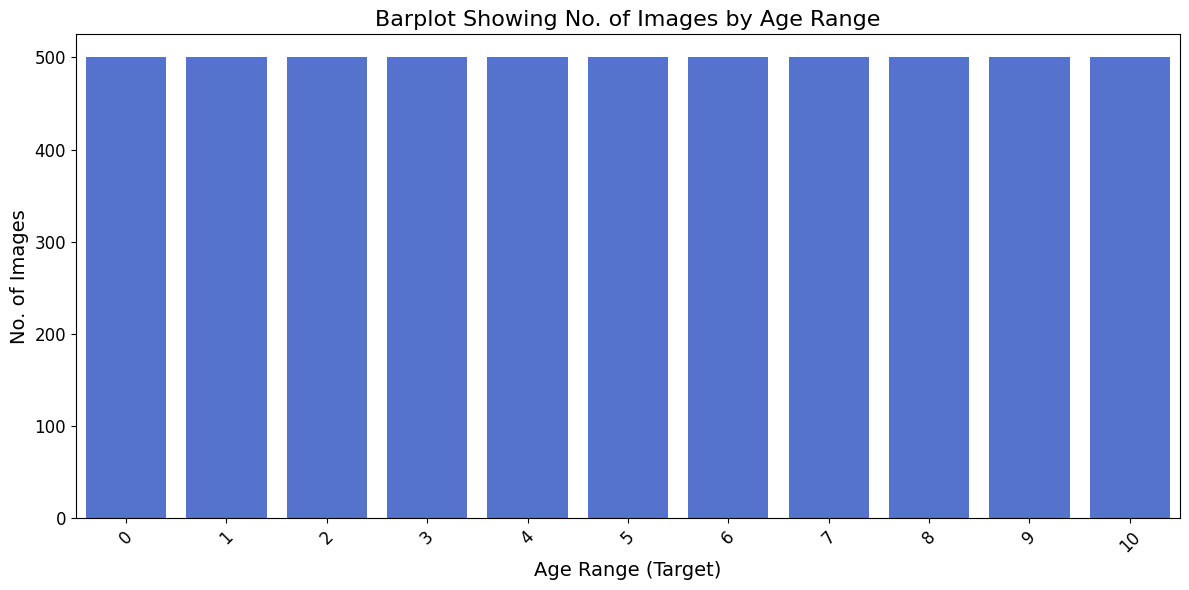

In [ ]:
target_counts = augmented_df['target'].value_counts().sort_index()

# Creating barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=target_counts.index, y=target_counts.values, color='royalblue')

ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelrotation=45)

plt.xlabel("Age Range (Target)", fontsize=14)
plt.ylabel("No. of Images", fontsize=14)
plt.title("Barplot Showing No. of Images by Age Range", fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
augmented_df.head(5000)

,filename,age,target
0,021_3095_original.png,21,4
1,021_3095_aug_0_0.png,21,4
2,021_3095_aug_0_1.png,21,4
3,021_3095_aug_0_2.png,21,4
4,021_2919_original.png,21,4
...,...,...,...
4995,075_7074_aug_4245_2.png,75,9
4996,080_2758_original.png,80,9
4997,080_2758_aug_4465_0.png,80,9
4998,080_2758_aug_4465_1.png,80,9
